/tmp/ipykernel_2758456/213912370.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


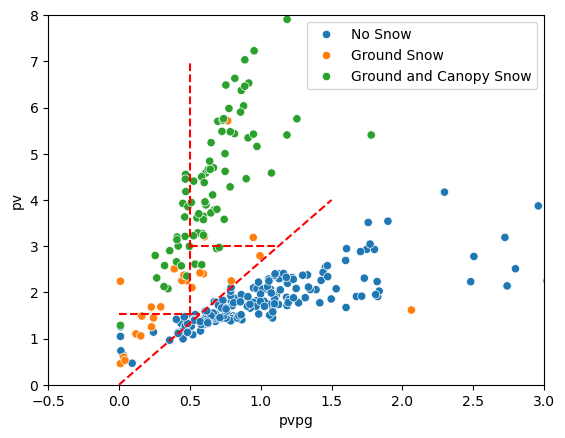

294


,camera,date,lat,lon,pvpg,pv,pg,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions
0,delta_junction,01/08/2021,63.849568,-145.741168,0.924094,1.740098,1.883032,33.000000,0.288152,0.0,0.0,0.0,18.0,0.000000,NaN,NaN,0.0,No Snow
2,delta_junction,01/08/2021,63.858577,-145.741168,0.595489,1.404310,2.358249,30.000000,0.288152,0.0,0.0,0.0,18.0,0.000000,NaN,NaN,0.0,No Snow
4,delta_junction,01/08/2021,63.876595,-145.741168,0.243051,1.138873,4.685735,31.000000,0.283702,0.0,0.0,0.0,18.0,0.000000,NaN,NaN,0.0,No Snow
6,delta_junction,01/08/2021,63.885605,-145.741168,0.451737,1.245196,2.756459,42.000000,0.280986,0.0,0.0,0.0,18.0,0.000000,NaN,NaN,0.0,No Snow
8,delta_junction,01/08/2021,63.894614,-145.741168,0.437683,1.326541,3.030829,28.000000,0.280986,0.0,0.0,0.0,18.0,0.000000,NaN,NaN,0.0,No Snow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1285,torgnon,21/05/2020,45.828305,7.515652,2.797484,2.510851,0.897539,25.782609,0.086268,0.0,0.0,0.0,8.0,1.347826,1.630907,1.630907,0.0,No Snow
1297,torgnon,22/02/2022,45.828305,7.528580,9.625301,2.651121,0.275433,25.000000,0.280443,1.0,0.0,0.0,18.0,0.000000,NaN,NaN,1.0,Ground Snow
1299,torgnon,23/08/2022,45.819295,7.554436,2.481689,2.230456,0.898765,21.975610,0.186102,0.0,0.0,0.0,21.0,0.000000,1.579313,1.579313,0.0,No Snow
1300,torgnon,23/08/2022,45.828305,7.554436,1.730994,2.306458,1.332447,22.612903,0.214997,0.0,0.0,0.0,21.0,0.000000,1.602506,1.602506,0.0,No Snow


In [63]:
from scripts.imports import *

df = pd.read_pickle('dataset_landcover_forest_22_th3_1km_noprior.pkl')
# print(df.columns)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'file_index': 'mean',
    'layer_flag': 'mean',
    'msw_flag': 'mean',
    'cloud_flag_atm': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
    'segment_landcover': pd.Series.mode,
}).reset_index()
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    # &(df_grouped['pvpg']>.5)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.8)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.5)&(df_grouped['pv']>2)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<.5)&((df_grouped['FSC'] < .5)|(df_grouped['TreeSnow'] > 0))

    &~(df_grouped['pv_ratio_mean'] <= 1.2)

    # &(df_grouped['data_quantity'] >= 18)]
    &((df_grouped['layer_flag'] <= .7)|(df_grouped['msw_flag'] < 1))&(df_grouped['data_quantity'] >= 18)]
    # &(df_grouped['layer_flag'] <= .8)&(df_grouped['data_quantity'] > 10)]

data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.ceil(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlim(-.5,3)
plt.ylim(0,8)
plt.plot([0,1.5],[0,4],'r--')
plt.plot([0.5,1.1],[3,3],'r--')
plt.plot([0,0.57],[1.53,1.53],'r--')
plt.plot([0.5,0.5],[1.53,7],'r--')
plt.legend(loc='best')
plt.show()
print(len(data))
data

/tmp/ipykernel_2758456/1877079589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'classification'] = data.apply(


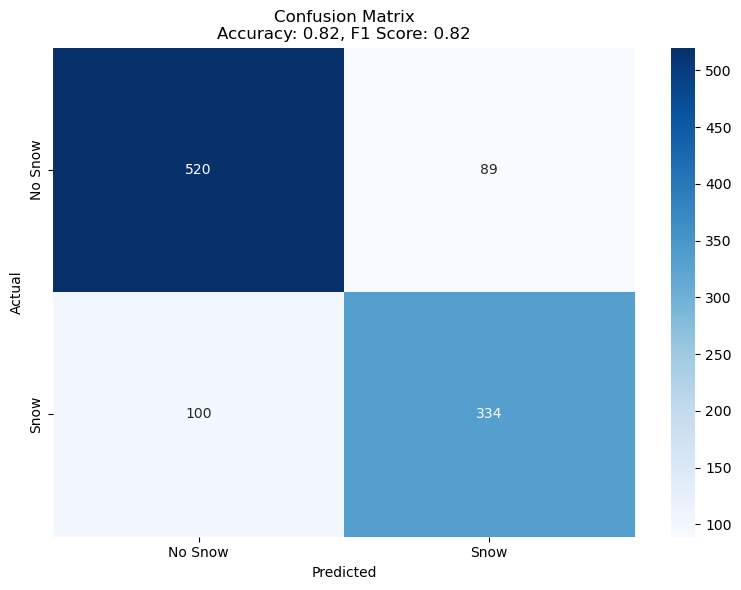

,camera,date,lat,lon,pvpg,pv,pg,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,classification
1323,torgnon,30/05/2019,45.819295,7.528580,0.484326,1.123240,2.319184,3.000000,0.179918,0.0,0.0,0.0,4.0,0.0000,NaN,NaN,0.0,No Snow,1
1321,torgnon,30/05/2019,45.801277,7.528580,0.142857,1.714286,11.999993,3.000000,0.225920,0.0,0.0,0.0,4.0,0.0000,NaN,NaN,0.0,No Snow,1
996,sodankyla_full,07/10/2021,67.384356,26.669262,0.025173,0.402749,15.999335,3.000000,140.711746,0.0,0.0,1.0,21.0,2.0000,NaN,NaN,0.0,No Snow,1
239,delta_junction,28/07/2023,63.849568,-145.700240,0.010000,0.309618,30.961806,3.000000,0.374551,0.0,0.0,0.0,27.0,0.0000,NaN,NaN,0.0,No Snow,1
241,delta_junction,28/07/2023,63.876595,-145.720704,0.084563,0.406270,4.804327,3.000000,0.374551,0.0,0.0,0.0,27.0,0.0000,NaN,NaN,0.0,No Snow,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,sodankyla_full,11/06/2020,67.330301,26.552235,0.404432,1.416190,3.501680,28.892857,9.363135,0.0,0.0,0.0,12.0,0.0000,1.488962,1.488962,0.0,No Snow,1
4,delta_junction,01/08/2021,63.876595,-145.741168,0.243051,1.138873,4.685735,31.000000,0.283702,0.0,0.0,0.0,18.0,0.0000,NaN,NaN,0.0,No Snow,1
235,delta_junction,28/04/2023,63.885605,-145.802560,1.654527,2.730392,1.650255,32.000000,0.108515,1.0,0.0,1.0,25.0,1.5625,NaN,NaN,1.0,Ground Snow,0
1220,sodankyla_full,24/01/2019,67.330301,26.645857,1.359172,1.484146,1.091949,34.000000,0.359874,1.0,1.0,1.0,1.0,3.0000,NaN,NaN,2.0,Ground and Canopy Snow,0


In [57]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

data.loc[:, 'classification'] = data.apply(
    # lambda row: 1 if row['pvpg'] <= 0.5 else (1 if row['pv'] > 3.8 * row['pvpg'] - 0.3 else 0),
    lambda row: 1 if row['pvpg'] <= 0.5 else (0 if row['pvpg'] > 1.5 else (1 if row['pv'] > 3 else (1 if row['pv'] > 8/3 * row['pvpg'] else 0))),
    axis=1
)

data.loc[:, 'FSC'] = data['FSC'].apply(lambda x: round(x))#.astype(int)

# Compute confusion matrix
labels = ['No Snow', 'Snow']
cm = confusion_matrix(data['FSC'], data['classification'])

# Calculate accuracy and F1 score
accuracy = accuracy_score(data['FSC'], data['classification'])
f1 = f1_score(data['FSC'], data['classification'], average='weighted')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')
plt.tight_layout()
plt.show()
data[(((data['classification']==0)&(data['FSC']>.95))|((data['classification']==1)&(data['FSC']<.05)))].sort_values('data_quantity')

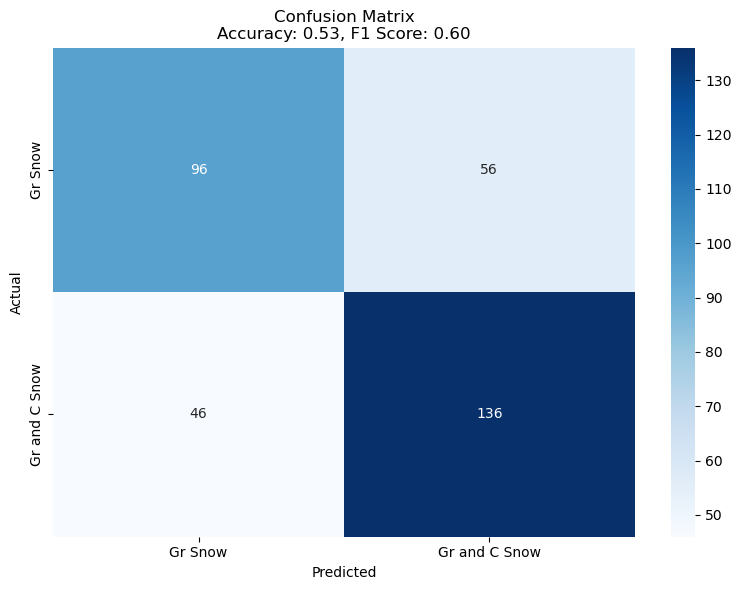

,camera,date,lat,lon,pvpg,pv,pg,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,classification
164,delta_junction,15/11/2018,63.885605,-145.700240,0.010000,0.141220,14.121951,3.000000,1.236282,1.0,1.0,1.0,1.0,3.0,NaN,NaN,2.0,Ground and Canopy Snow,1
1065,sodankyla_full,11/04/2020,67.357328,26.669262,1.250000,6.297619,5.038095,3.000000,360.712799,1.0,0.0,0.0,10.0,0.0,NaN,NaN,1.0,Ground Snow,2
949,sodankyla_full,03/01/2024,67.393365,26.669262,0.010000,0.438690,43.869048,3.000000,456.820526,1.0,1.0,1.0,33.0,1.0,NaN,NaN,2.0,Ground and Canopy Snow,1
313,lacclair,03/04/2024,46.974623,-71.715793,0.466178,1.942591,4.167056,3.000000,157.922607,1.0,0.0,1.0,22.0,0.0,1.778002,1.778002,1.0,Ground Snow,2
483,marcell_MN,18/03/2023,47.518414,-93.434096,0.010002,1.961726,196.129323,3.000000,0.463288,1.0,0.0,1.0,22.0,4.0,NaN,NaN,1.0,Ground Snow,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,lacclair,03/12/2019,46.983632,-71.649803,0.583964,2.596757,4.446774,28.571429,179.466010,1.0,0.3,0.0,4.0,0.0,2.315128,2.315128,2.0,Ground and Canopy Snow,1
412,lacclair,31/01/2021,46.974623,-71.676199,0.689618,2.945879,4.271756,29.508475,171.513570,1.0,0.6,0.0,10.0,0.0,2.173446,2.173446,2.0,Ground and Canopy Snow,1
138,delta_junction,11/11/2020,63.894614,-145.802560,0.154452,1.250921,8.099073,30.533333,26.277282,1.0,1.0,1.0,13.0,2.0,1.355394,1.355394,2.0,Ground and Canopy Snow,1
986,sodankyla_full,07/03/2023,67.375347,26.552235,0.527936,3.266476,6.187259,31.290323,7.217271,1.0,0.0,1.0,28.0,3.0,3.138014,3.138014,1.0,Ground Snow,2


In [58]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# data.loc[:, 'classification'] = data.apply(
#     # lambda row: 1 if row['pvpg'] <= 0.5 else (2 if row['pv'] > 3.8 * row['pvpg'] - 0.3 else 0),
#     lambda row: 1 if row['pvpg'] <= 0.5 else (0 if row['pvpg'] > 1.5 else (2 if row['pv'] > 4 else (1 if row['pv'] > 8/3 * row['pvpg'] else 0))),
#     axis=1
# )
data.loc[:, 'classification'] = data.apply(
    # lambda row: 1 if row['pvpg'] <= 0.5 else (2 if row['pv'] > 3.8 * row['pvpg'] - 0.3 else 0),
    lambda row: 1 if (row['pvpg'] <= 0.5)&(row['pv'] <= 1.53) else (2 if row['pvpg'] <= 0.5 else (0 if row['pvpg'] > 1.5 else (2 if row['pv'] > 3 else (1 if row['pv'] > 8/3 * row['pvpg'] else 0)))),
    axis=1
)

data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.ceil(x))#.astype(int)

# Compute confusion matrix
labels = ['Gr Snow', 'Gr and C Snow']
cm = confusion_matrix(data[~((data['JointSnow']==0)|(data['classification']==0))]['JointSnow'], data[~((data['JointSnow']==0)|(data['classification']==0))]['classification'])

# Calculate accuracy and F1 score
accuracy = accuracy_score(data[data['JointSnow']!=0]['JointSnow'], data[data['JointSnow']!=0]['classification'])
f1 = f1_score(data[data['JointSnow']!=0]['JointSnow'], data[data['JointSnow']!=0]['classification'], average='weighted')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')
plt.tight_layout()
plt.show()
data[((data['classification']==1)&(data['JointSnow']==2))|
    ((data['classification']==2)&(data['JointSnow']==1))].sort_values('data_quantity')

/tmp/ipykernel_4161567/3056082633.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


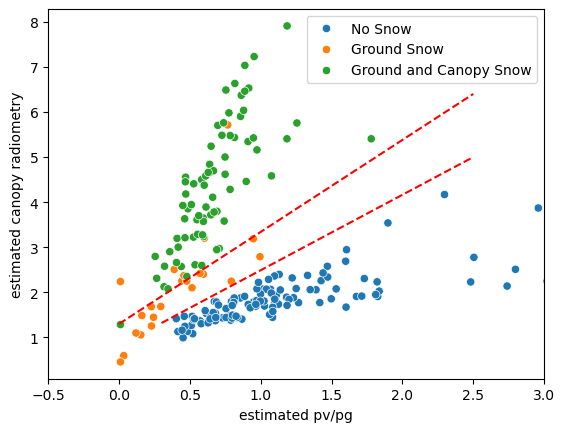

218


,camera,date,lat,lon,pvpg,pv,pg,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions
873,oregon_yp,22/10/2020,44.346323,-121.599704,1.055350,2.287444,2.167475,25.745098,1.231311,0.0,0.0,0.000000,11.0,0.0,1.837281,1.837281,0.0,No Snow
851,oregon_yp,21/04/2021,44.346323,-121.574518,0.579581,1.303783,2.249527,25.580645,0.789260,0.0,0.0,0.000000,13.0,0.0,1.374478,1.374478,0.0,No Snow
852,oregon_yp,21/04/2021,44.355332,-121.612296,0.460227,1.468410,3.190625,26.941176,0.862250,0.0,0.0,0.323529,13.0,0.0,1.346565,1.346565,0.0,No Snow
853,oregon_yp,21/04/2021,44.355332,-121.574518,1.023340,1.807572,1.766345,25.681818,0.664699,0.0,0.0,0.000000,13.0,0.0,1.524038,1.524038,0.0,No Snow
854,oregon_yp,21/07/2021,44.292268,-121.637482,0.483148,1.133396,2.345857,18.280000,72.286031,0.0,0.0,1.000000,15.0,0.0,1.377524,1.377524,0.0,No Snow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,sodankyla_full,20/09/2021,67.348319,26.575640,0.728970,1.434222,1.967465,28.450000,1.132826,0.0,0.0,0.400000,20.0,2.0,1.365551,1.365551,0.0,No Snow
1005,sodankyla_full,08/06/2022,67.384356,26.599046,1.084467,1.667799,1.537897,21.800000,0.571321,0.0,0.0,0.350000,25.0,2.0,1.347561,1.347561,0.0,No Snow
870,oregon_yp,22/10/2020,44.337314,-121.637482,1.185652,1.711519,1.443525,19.230769,0.597225,0.0,0.0,0.153846,11.0,2.0,1.297357,1.297357,0.0,No Snow
645,marcell_MN,28/07/2022,47.482377,-93.447432,1.712916,1.916596,1.118909,24.600000,0.196911,0.0,0.0,0.433333,18.0,2.0,1.330416,1.330416,0.0,No Snow


In [1]:
from scripts.imports import *

df = pd.read_pickle('dataset_landcover_forest_22_th3_1km_noprior.pkl')
# print(df.columns)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean'
}).reset_index()
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    # &(df_grouped['pvpg']>.5)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.8)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.5)&(df_grouped['pv']>2)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<.5)&((df_grouped['FSC'] < .5)|(df_grouped['TreeSnow'] > 0))

    &(df_grouped['pv_ratio_mean'] >= 1.2)

    # &(df_grouped['data_quantity'] >= 18)]
    &((df_grouped['layer_flag'] <= .7)|(df_grouped['msw_flag'] < 1))&(df_grouped['data_quantity'] >= 18)]
    # &(df_grouped['layer_flag'] <= .8)&(df_grouped['data_quantity'] > 10)]

data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.ceil(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pv/pg')
plt.ylabel('estimated canopy radiometry')
plt.xlim(-.5,3)
# plt.ylim(0,12)
plt.plot([0.3,2.5],[1.32,5],'r--')
plt.plot([0,2.5],[1.3,6.4],'r--')
# plt.plot([0.29,0.29],[0,1.32],'r--')
# plt.plot([0.5,0.5],[1.53,7],'r--')
plt.legend(loc='best')
plt.show()
print(len(data))
data.sort_values('msw_flag')

/tmp/ipykernel_2389290/3043025698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'classification'] = data.apply(


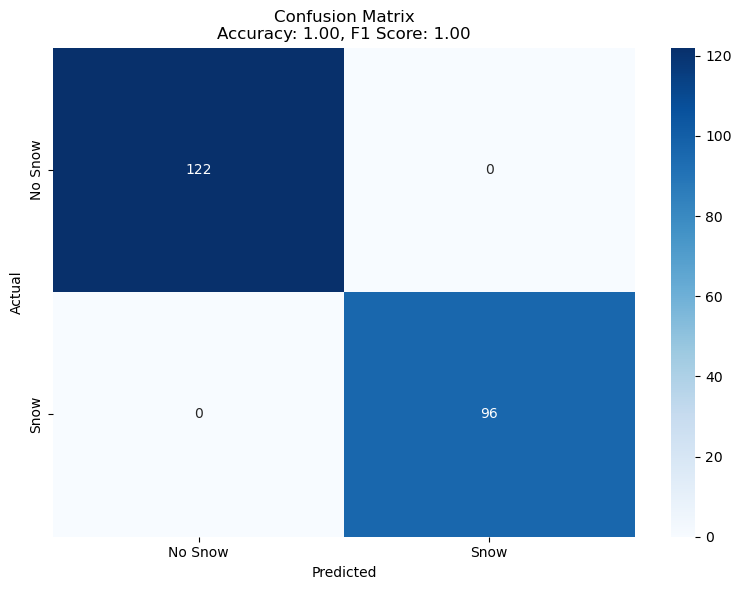

,camera,date,lat,lon,pvpg,pv,pg,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,classification


In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# data.loc[:, 'classification'] = data.apply(
#     # lambda row: 1 if row['pvpg'] <= 0.5 else (2 if row['pv'] > 3.8 * row['pvpg'] - 0.3 else 0),
#     lambda row: 1 if row['pvpg'] <= 0.5 else (0 if row['pvpg'] > 1.5 else (2 if row['pv'] > 4 else (1 if row['pv'] > 8/3 * row['pvpg'] else 0))),
#     axis=1
# )
data.loc[:, 'classification'] = data.apply(
    # lambda row: 1 if row['pvpg'] <= 0.5 else (2 if row['pv'] > 3.8 * row['pvpg'] - 0.3 else 0),
    lambda row: 0 if (row['pvpg'] >= 0.29)&(row['pv'] <= 3.68/2.2*(row['pvpg']-.3)+1.32) else (1 if row['pv'] >= 5.1/2.5*row['pvpg']+1.3 else 1),
    axis=1
)

data.loc[:, 'FSC'] = data['FSC'].apply(lambda x: np.ceil(x))#.astype(int)

# Compute confusion matrix
labels = ['No Snow', 'Snow']
cm = confusion_matrix(data['FSC'],data['classification'])

# Calculate accuracy and F1 score
accuracy = accuracy_score(data['FSC'], data['classification'])
f1 = f1_score(data['FSC'], data['classification'], average='weighted')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')
plt.tight_layout()
plt.show()
data[(((data['classification']==0)&(data['FSC']>.95))|((data['classification']==1)&(data['FSC']<.05)))].sort_values('data_quantity')

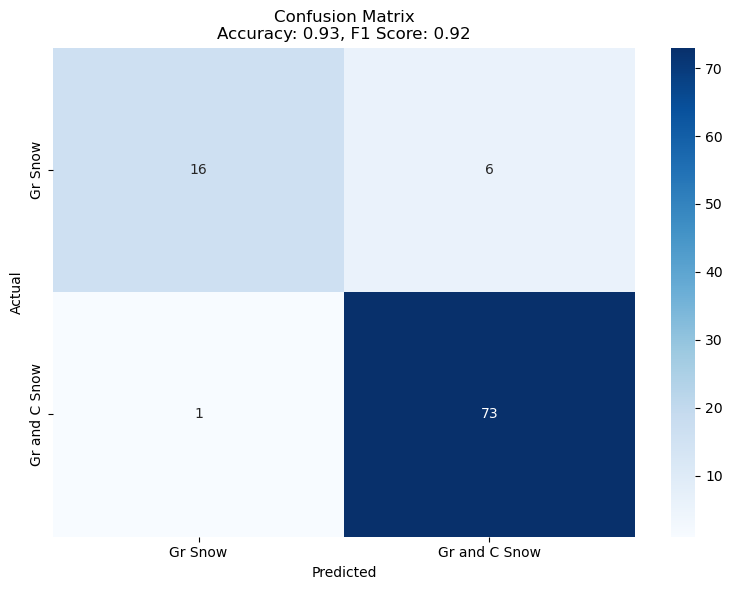

,camera,date,lat,lon,pvpg,pv,pg,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,classification
1145,sodankyla_full,19/03/2023,67.384356,26.575640,0.010000,1.284602,128.460182,19.210526,1.063886,1.0,1.0,0.000000,29.0,0.000000,3.952379,3.952379,2.0,Ground and Canopy Snow,1
1108,sodankyla_full,16/03/2024,67.330301,26.575640,0.389964,2.508284,6.432095,19.512821,3.868688,1.0,0.0,0.000000,35.0,0.000000,2.918038,2.918038,1.0,Ground Snow,2
494,marcell_MN,20/03/2022,47.482377,-93.434096,0.458141,2.371965,5.177373,20.450000,241.259816,1.0,0.0,0.000000,16.0,0.000000,2.907656,2.907656,1.0,Ground Snow,2
952,sodankyla_full,03/04/2024,67.330301,26.692668,0.602343,3.201936,5.315801,23.000000,116.193775,1.0,0.0,0.000000,36.0,0.000000,2.686547,2.686547,1.0,Ground Snow,2
1248,torgnon,14/02/2023,45.810286,7.541508,0.010000,2.239824,223.982353,25.761905,0.158256,1.0,0.0,0.000000,22.0,0.000000,1.331304,1.331304,1.0,Ground Snow,2
314,lacclair,03/04/2024,46.974623,-71.676199,0.443582,2.252947,5.078989,27.581818,181.601900,1.0,0.0,1.000000,22.0,0.000000,1.829352,1.829352,1.0,Ground Snow,2
61,delta_junction,05/01/2020,63.912632,-145.802560,0.767152,5.712628,7.446544,28.529412,116.616700,1.0,0.0,0.323529,6.0,0.647059,3.450034,3.450034,1.0,Ground Snow,2


In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# data.loc[:, 'classification'] = data.apply(
#     # lambda row: 1 if row['pvpg'] <= 0.5 else (2 if row['pv'] > 3.8 * row['pvpg'] - 0.3 else 0),
#     lambda row: 1 if row['pvpg'] <= 0.5 else (0 if row['pvpg'] > 1.5 else (2 if row['pv'] > 4 else (1 if row['pv'] > 8/3 * row['pvpg'] else 0))),
#     axis=1
# )
data.loc[:, 'classification'] = data.apply(
    # lambda row: 1 if row['pvpg'] <= 0.5 else (2 if row['pv'] > 3.8 * row['pvpg'] - 0.3 else 0),
    lambda row: 0 if (row['pvpg'] >= 0.5)&(row['pv'] <= 3.68/2.2*(row['pvpg']-.3)+1.32) else (2 if row['pv'] >= 5.1/2.5*row['pvpg']+1.3 else 1),
    axis=1
)

# print(data[data['classification']!=0]['JointSnow'])

# Compute confusion matrix
labels = ['Gr Snow', 'Gr and C Snow']
cm = confusion_matrix(data[~((data['JointSnow']==0)|(data['classification']==0))]['JointSnow'], data[~((data['JointSnow']==0)|(data['classification']==0))]['classification'])

# Calculate accuracy and F1 score
accuracy = accuracy_score(data[~((data['JointSnow']==0)|(data['classification']==0))]['JointSnow'], data[~((data['JointSnow']==0)|(data['classification']==0))]['classification'])
f1 = f1_score(data[~((data['JointSnow']==0)|(data['classification']==0))]['JointSnow'], data[~((data['JointSnow']==0)|(data['classification']==0))]['classification'], average='weighted')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')
plt.tight_layout()
plt.show()
data[((data['classification']==1)&(data['JointSnow']==2))|
    ((data['classification']==2)&(data['JointSnow']==1))].sort_values('data_quantity')

### trim_atmospheric active

/tmp/ipykernel_2389290/2406233121.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


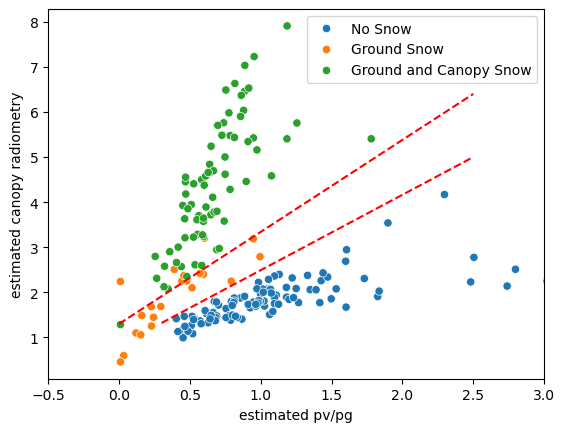

201


,camera,date,lat,lon,pvpg,pv,pg,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions
767,torgnon,14/02/2023,45.810286,7.541508,0.010000,2.239824,223.982353,25.761905,0.158256,1.0,0.0,0.00,22.0,0.000000,1.331304,1.331304,1.0,Ground Snow
716,sodankyla_full,19/03/2023,67.384356,26.575640,0.010000,1.284602,128.460182,19.210526,1.063886,1.0,1.0,0.00,29.0,0.000000,3.952379,3.952379,2.0,Ground and Canopy Snow
283,marcell_MN,20/03/2022,47.473368,-93.434096,0.010000,0.456932,45.693013,18.837838,240.184526,1.0,0.0,0.00,16.0,0.000000,1.830670,1.830670,1.0,Ground Snow
704,sodankyla_full,16/03/2024,67.393365,26.552235,0.033449,0.596839,17.843109,18.657143,4.332858,1.0,0.0,0.00,35.0,0.000000,1.594764,1.594764,1.0,Ground Snow
706,sodankyla_full,16/03/2024,67.393365,26.692668,0.119818,1.098676,9.169559,20.450000,3.408555,1.0,0.0,0.00,35.0,0.000000,3.044062,3.044062,1.0,Ground Snow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,lacclair,13/07/2019,46.920568,-71.689397,4.554463,2.267037,0.497762,30.285714,0.313856,0.0,0.0,0.25,1.0,0.000000,1.339686,1.339686,0.0,No Snow
242,lacclair,13/07/2019,46.956605,-71.689397,4.676571,2.192539,0.468835,19.882353,0.326939,0.0,0.0,0.00,1.0,0.000000,1.467556,1.467556,0.0,No Snow
244,lacclair,13/07/2019,46.965614,-71.689397,5.394028,2.177343,0.403658,29.750000,0.313601,0.0,0.0,0.00,1.0,0.000000,1.326006,1.326006,0.0,No Snow
249,lacclair,13/07/2019,46.983632,-71.689397,14.581276,3.051767,0.209294,24.909091,0.334865,0.0,0.0,0.00,1.0,0.477273,1.215771,1.215771,0.0,No Snow


In [4]:
from scripts.imports import *

df = pd.read_pickle('dataset_landcover_forest_22_th3_1km_noprior_ta.pkl')
# print(df.columns)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    # 'pv_ratio': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean'
}).reset_index()
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    # &(df_grouped['pvpg']>.5)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.8)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.5)&(df_grouped['pv']>2)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<.5)&((df_grouped['FSC'] < .5)|(df_grouped['TreeSnow'] > 0))

    &(df_grouped['pv_ratio_mean'] >= 1.2)

    # &(df_grouped['data_quantity'] >= 18)]
    &((df_grouped['layer_flag'] <= .7)|(df_grouped['msw_flag'] < 1))&(df_grouped['data_quantity'] >= 18)]
    # &(df_grouped['layer_flag'] <= .8)&(df_grouped['data_quantity'] > 10)]

data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.ceil(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pv/pg')
plt.ylabel('estimated canopy radiometry')
plt.xlim(-.5,3)
# plt.ylim(0,12)
plt.plot([0.3,2.5],[1.32,5],'r--')
plt.plot([0,2.5],[1.3,6.4],'r--')
# plt.plot([0.29,0.29],[0,1.32],'r--')
# plt.plot([0.5,0.5],[1.53,7],'r--')
plt.legend(loc='best')
plt.show()
print(len(data))
data.sort_values('pvpg')

/tmp/ipykernel_2389290/3043025698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'classification'] = data.apply(


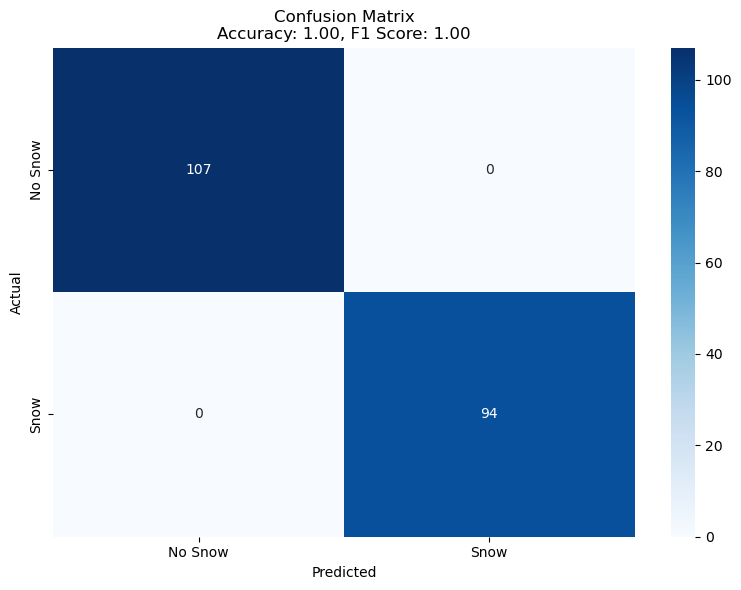

,camera,date,lat,lon,pvpg,pv,pg,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,classification


In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# data.loc[:, 'classification'] = data.apply(
#     # lambda row: 1 if row['pvpg'] <= 0.5 else (2 if row['pv'] > 3.8 * row['pvpg'] - 0.3 else 0),
#     lambda row: 1 if row['pvpg'] <= 0.5 else (0 if row['pvpg'] > 1.5 else (2 if row['pv'] > 4 else (1 if row['pv'] > 8/3 * row['pvpg'] else 0))),
#     axis=1
# )
data.loc[:, 'classification'] = data.apply(
    # lambda row: 1 if row['pvpg'] <= 0.5 else (2 if row['pv'] > 3.8 * row['pvpg'] - 0.3 else 0),
    lambda row: 0 if (row['pvpg'] >= 0.29)&(row['pv'] <= 3.68/2.2*(row['pvpg']-.3)+1.32) else (1 if row['pv'] >= 5.1/2.5*row['pvpg']+1.3 else 1),
    axis=1
)

data.loc[:, 'FSC'] = data['FSC'].apply(lambda x: np.ceil(x))#.astype(int)

# Compute confusion matrix
labels = ['No Snow', 'Snow']
cm = confusion_matrix(data['FSC'],data['classification'])

# Calculate accuracy and F1 score
accuracy = accuracy_score(data['FSC'], data['classification'])
f1 = f1_score(data['FSC'], data['classification'], average='weighted')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')
plt.tight_layout()
plt.show()
data[(((data['classification']==0)&(data['FSC']>.95))|((data['classification']==1)&(data['FSC']<.05)))].sort_values('data_quantity')

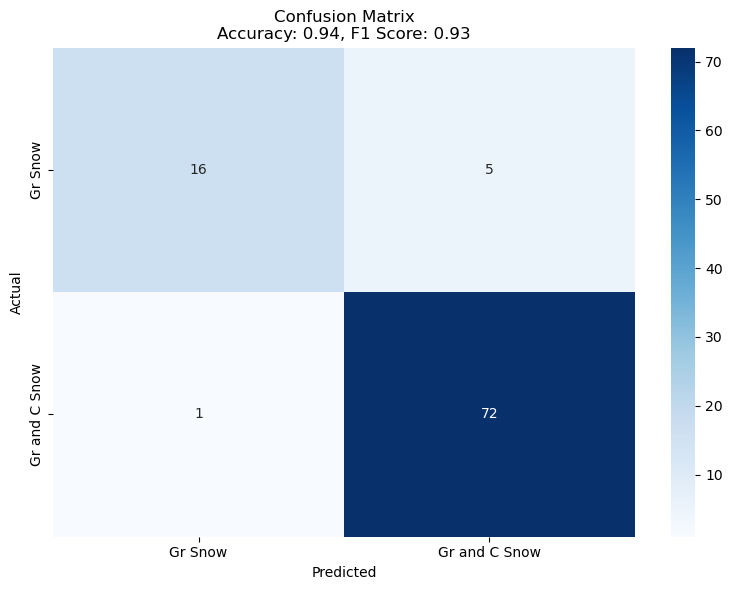

,camera,date,lat,lon,pvpg,pv,pg,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,classification
716,sodankyla_full,19/03/2023,67.384356,26.575640,0.010000,1.284602,128.460182,19.210526,1.063886,1.0,1.0,0.0,29.0,0.0,3.952379,3.952379,2.0,Ground and Canopy Snow,1
685,sodankyla_full,16/03/2024,67.330301,26.575640,0.389964,2.508284,6.432095,19.512821,3.868688,1.0,0.0,0.0,35.0,0.0,2.918038,2.918038,1.0,Ground Snow,2
284,marcell_MN,20/03/2022,47.482377,-93.434096,0.458141,2.371965,5.177373,20.450000,241.259816,1.0,0.0,0.0,16.0,0.0,2.907656,2.907656,1.0,Ground Snow,2
583,sodankyla_full,03/04/2024,67.330301,26.692668,0.602343,3.201936,5.315801,23.000000,116.193775,1.0,0.0,0.0,36.0,0.0,2.686547,2.686547,1.0,Ground Snow,2
767,torgnon,14/02/2023,45.810286,7.541508,0.010000,2.239824,223.982353,25.761905,0.158256,1.0,0.0,0.0,22.0,0.0,1.331304,1.331304,1.0,Ground Snow,2
191,lacclair,03/04/2024,46.974623,-71.676199,0.443582,2.252947,5.078989,27.581818,181.601900,1.0,0.0,1.0,22.0,0.0,1.829352,1.829352,1.0,Ground Snow,2


In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# data.loc[:, 'classification'] = data.apply(
#     # lambda row: 1 if row['pvpg'] <= 0.5 else (2 if row['pv'] > 3.8 * row['pvpg'] - 0.3 else 0),
#     lambda row: 1 if row['pvpg'] <= 0.5 else (0 if row['pvpg'] > 1.5 else (2 if row['pv'] > 4 else (1 if row['pv'] > 8/3 * row['pvpg'] else 0))),
#     axis=1
# )
data.loc[:, 'classification'] = data.apply(
    # lambda row: 1 if row['pvpg'] <= 0.5 else (2 if row['pv'] > 3.8 * row['pvpg'] - 0.3 else 0),
    lambda row: 0 if (row['pvpg'] >= 0.5)&(row['pv'] <= 3.68/2.2*(row['pvpg']-.3)+1.32) else (2 if row['pv'] >= 5.1/2.5*row['pvpg']+1.3 else 1),
    axis=1
)

# print(data[data['classification']!=0]['JointSnow'])

# Compute confusion matrix
labels = ['Gr Snow', 'Gr and C Snow']
cm = confusion_matrix(data[~((data['JointSnow']==0)|(data['classification']==0))]['JointSnow'], data[~((data['JointSnow']==0)|(data['classification']==0))]['classification'])

# Calculate accuracy and F1 score
accuracy = accuracy_score(data[~((data['JointSnow']==0)|(data['classification']==0))]['JointSnow'], data[~((data['JointSnow']==0)|(data['classification']==0))]['classification'])
f1 = f1_score(data[~((data['JointSnow']==0)|(data['classification']==0))]['JointSnow'], data[~((data['JointSnow']==0)|(data['classification']==0))]['classification'], average='weighted')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, F1 Score: {f1:.2f}')
plt.tight_layout()
plt.show()
data[((data['classification']==1)&(data['JointSnow']==2))|
    ((data['classification']==2)&(data['JointSnow']==1))].sort_values('data_quantity')

### plot pg instead of pv

/tmp/ipykernel_4039279/3678823555.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


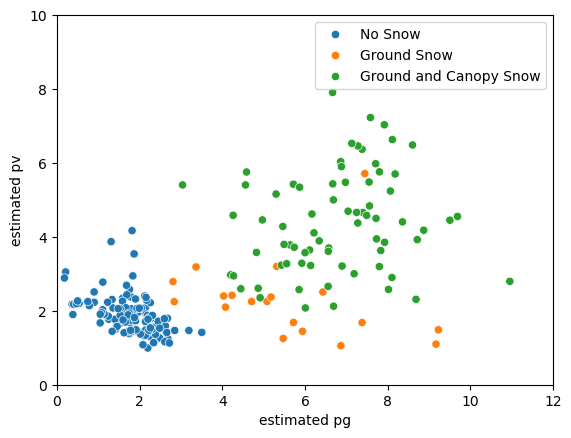

218


,camera,date,lat,lon,pvpg,pv,pg,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions
1248,torgnon,14/02/2023,45.810286,7.541508,0.010000,2.239824,223.982353,25.761905,0.158256,1.0,0.0,0.0,22.0,0.000000,1.331304,1.331304,1.0,Ground Snow
1145,sodankyla_full,19/03/2023,67.384356,26.575640,0.010000,1.284602,128.460182,19.210526,1.063886,1.0,1.0,0.0,29.0,0.000000,3.952379,3.952379,2.0,Ground and Canopy Snow
493,marcell_MN,20/03/2022,47.473368,-93.434096,0.010000,0.456932,45.693013,18.837838,240.184526,1.0,0.0,0.0,16.0,0.000000,1.830670,1.830670,1.0,Ground Snow
1127,sodankyla_full,16/03/2024,67.393365,26.552235,0.033449,0.596839,17.843109,18.657143,4.332858,1.0,0.0,0.0,35.0,0.000000,1.594764,1.594764,1.0,Ground Snow
1129,sodankyla_full,16/03/2024,67.393365,26.692668,0.119818,1.098676,9.169559,20.450000,3.408555,1.0,0.0,0.0,35.0,0.000000,3.044062,3.044062,1.0,Ground Snow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,lacclair,29/05/2022,46.956605,-71.623407,4.950729,1.899123,0.383605,20.315789,114.941279,0.0,0.0,1.0,14.0,0.789474,1.213380,1.213380,0.0,No Snow
378,lacclair,13/07/2019,46.965614,-71.689397,5.394028,2.177343,0.403658,29.750000,0.313601,0.0,0.0,0.0,1.0,0.000000,1.326006,1.326006,0.0,No Snow
1254,torgnon,15/08/2023,45.828305,7.528580,5.988662,2.179168,0.363882,20.400000,27.451538,0.0,0.0,1.0,26.0,0.200000,1.457101,1.457101,0.0,No Snow
383,lacclair,13/07/2019,46.983632,-71.689397,14.581276,3.051767,0.209294,24.909091,0.334865,0.0,0.0,0.0,1.0,0.477273,1.215771,1.215771,0.0,No Snow


In [12]:
from scripts.imports import *

df = pd.read_pickle('dataset_landcover_forest_22_th3_1km_noprior.pkl')
# print(df.columns)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean'
}).reset_index()
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    # &(df_grouped['pvpg']>.5)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.8)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.5)&(df_grouped['pv']>2)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<.5)&((df_grouped['FSC'] < .5)|(df_grouped['TreeSnow'] > 0))

    &(df_grouped['pv_ratio_mean'] >= 1.2)

    # &(df_grouped['data_quantity'] >= 18)]
    &((df_grouped['layer_flag'] <= .7)|(df_grouped['msw_flag'] < 1))&(df_grouped['data_quantity'] >= 18)]
    # &(df_grouped['layer_flag'] <= .8)&(df_grouped['data_quantity'] > 10)]

data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.ceil(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
plt.xlim(0,12)
plt.ylim(0,10)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()
print(len(data))
data.sort_values('pvpg')

/tmp/ipykernel_4039279/869589163.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


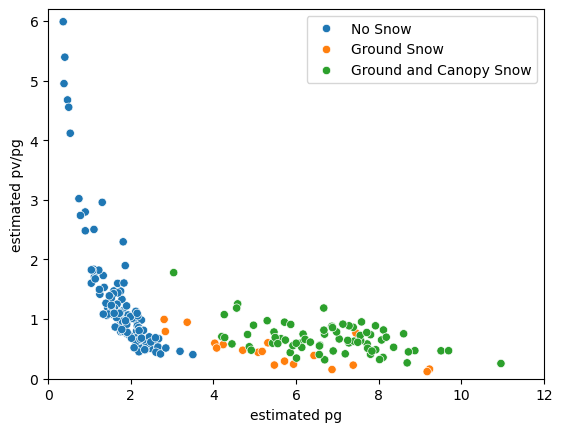

218


,camera,date,lat,lon,pvpg,pv,pg,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions
1248,torgnon,14/02/2023,45.810286,7.541508,0.010000,2.239824,223.982353,25.761905,0.158256,1.0,0.0,0.0,22.0,0.000000,1.331304,1.331304,1.0,Ground Snow
1145,sodankyla_full,19/03/2023,67.384356,26.575640,0.010000,1.284602,128.460182,19.210526,1.063886,1.0,1.0,0.0,29.0,0.000000,3.952379,3.952379,2.0,Ground and Canopy Snow
493,marcell_MN,20/03/2022,47.473368,-93.434096,0.010000,0.456932,45.693013,18.837838,240.184526,1.0,0.0,0.0,16.0,0.000000,1.830670,1.830670,1.0,Ground Snow
1127,sodankyla_full,16/03/2024,67.393365,26.552235,0.033449,0.596839,17.843109,18.657143,4.332858,1.0,0.0,0.0,35.0,0.000000,1.594764,1.594764,1.0,Ground Snow
1129,sodankyla_full,16/03/2024,67.393365,26.692668,0.119818,1.098676,9.169559,20.450000,3.408555,1.0,0.0,0.0,35.0,0.000000,3.044062,3.044062,1.0,Ground Snow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,lacclair,29/05/2022,46.956605,-71.623407,4.950729,1.899123,0.383605,20.315789,114.941279,0.0,0.0,1.0,14.0,0.789474,1.213380,1.213380,0.0,No Snow
378,lacclair,13/07/2019,46.965614,-71.689397,5.394028,2.177343,0.403658,29.750000,0.313601,0.0,0.0,0.0,1.0,0.000000,1.326006,1.326006,0.0,No Snow
1254,torgnon,15/08/2023,45.828305,7.528580,5.988662,2.179168,0.363882,20.400000,27.451538,0.0,0.0,1.0,26.0,0.200000,1.457101,1.457101,0.0,No Snow
383,lacclair,13/07/2019,46.983632,-71.689397,14.581276,3.051767,0.209294,24.909091,0.334865,0.0,0.0,0.0,1.0,0.477273,1.215771,1.215771,0.0,No Snow


In [13]:
from scripts.imports import *

df = pd.read_pickle('dataset_landcover_forest_22_th3_1km_noprior.pkl')
# print(df.columns)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean'
}).reset_index()
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    # &(df_grouped['pvpg']>.5)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.8)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.5)&(df_grouped['pv']>2)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<.5)&((df_grouped['FSC'] < .5)|(df_grouped['TreeSnow'] > 0))

    &(df_grouped['pv_ratio_mean'] >= 1.2)

    # &(df_grouped['data_quantity'] >= 18)]
    &((df_grouped['layer_flag'] <= .7)|(df_grouped['msw_flag'] < 1))&(df_grouped['data_quantity'] >= 18)]
    # &(df_grouped['layer_flag'] <= .8)&(df_grouped['data_quantity'] > 10)]

data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.ceil(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pvpg', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv/pg')
plt.xlim(0,12)
plt.ylim(0,6.2)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()
print(len(data))
data.sort_values('pvpg')

# All 19 Sites!

/tmp/ipykernel_2937322/3921361674.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


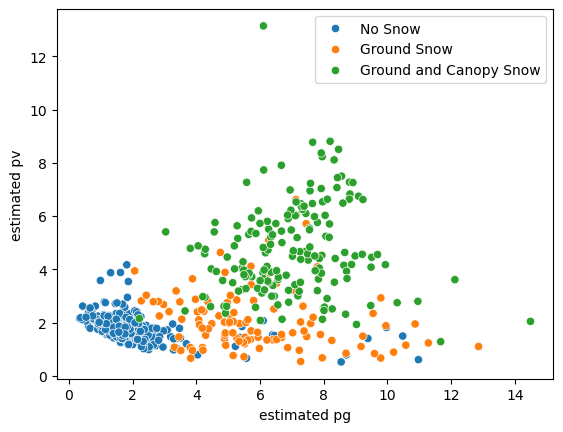

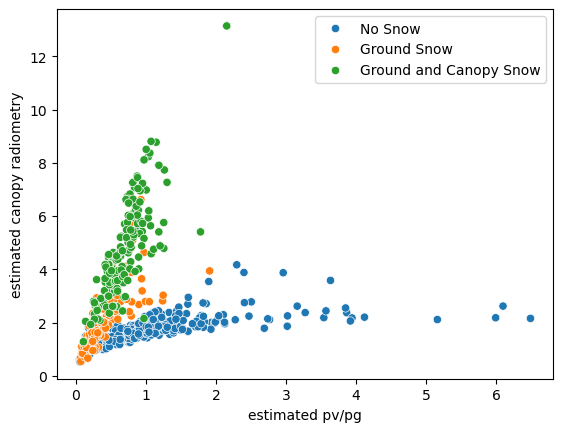

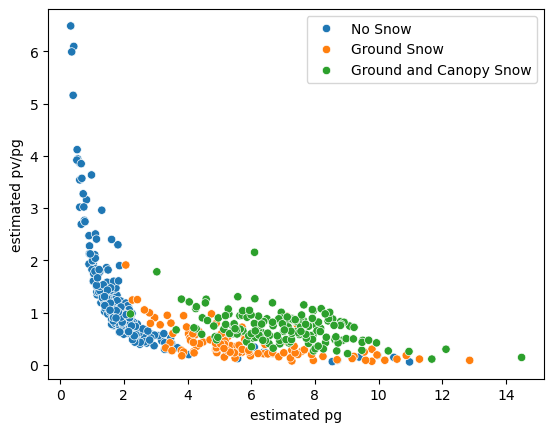

653


,camera,date,lat,lon,pvpg,pv,pg,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions
1549,old_jack_pine,09/10/2023,53.911795,-104.684352,0.055025,0.603731,10.971891,29.561404,99.058438,0.00,0.0,1.000000,23.0,0.000000,1.889532,1.889532,0.0,No Snow
1745,old_jack_pine,29/04/2023,53.902786,-104.638463,0.060719,0.518869,8.545366,27.641509,100.915144,0.00,0.0,1.000000,20.0,0.000000,2.162172,2.162172,0.0,No Snow
1520,old_jack_pine,07/05/2019,53.929814,-104.730241,0.067942,0.665062,9.788610,23.136364,1.759354,0.05,0.0,0.181818,4.0,2.000000,1.919312,1.919312,1.0,Ground Snow
1405,old_jack_pine,01/11/2020,53.884768,-104.684352,0.073490,0.534699,7.275784,27.641509,11.222090,1.00,0.0,0.000000,12.0,1.000000,2.070926,2.070926,1.0,Ground Snow
884,kenttarova,07/05/2019,67.973769,24.230965,0.084499,0.671833,7.950781,19.909091,1.822114,0.95,0.0,0.000000,2.0,0.000000,1.609643,1.609643,1.0,Ground Snow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,marcell_MN,22/06/2020,47.509405,-93.460768,4.117951,2.200378,0.534338,36.481481,0.506869,0.00,0.0,0.000000,6.0,1.185185,1.407269,1.407269,0.0,No Snow
2892,u_mich_bio,11/08/2019,45.564305,-84.733100,5.157402,2.111095,0.409333,24.860465,170.486289,0.00,0.0,1.000000,1.0,0.000000,1.334627,1.334627,0.0,No Snow
2735,torgnon,15/08/2023,45.828305,7.528580,5.988662,2.179168,0.363882,20.400000,27.451538,0.00,0.0,1.000000,26.0,0.200000,1.457101,1.457101,0.0,No Snow
2889,u_mich_bio,11/08/2019,45.555295,-84.733100,6.093756,2.617191,0.429487,25.470588,177.487517,0.00,0.0,1.000000,1.0,0.000000,1.673232,1.673232,0.0,No Snow


In [7]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_outlier22_th3_1km_noprior.pkl')
# print(df.columns)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean'
}).reset_index()
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    # &(df_grouped['pvpg']>.5)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.8)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.5)&(df_grouped['pv']>2)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<.5)&((df_grouped['FSC'] < .5)|(df_grouped['TreeSnow'] > 0))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)

    &(df_grouped['pv_ratio_mean'] >= 1.3)&(df_grouped['snr']>.5)

    # &(df_grouped['data_quantity'] >= 18)]
    &((df_grouped['layer_flag'] <= .7)|(df_grouped['msw_flag'] < 1))&(df_grouped['data_quantity'] >= 18)]
    # &(df_grouped['layer_flag'] <= .8)&(df_grouped['data_quantity'] > 10)]

data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.ceil(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
# plt.xlim(0,12)
# plt.ylim(0,10)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pv/pg')
plt.ylabel('estimated canopy radiometry')
# plt.xlim(0,3)
# plt.ylim(0,12)
# plt.plot([0.29,0.29],[0,1.32],'r--')
# plt.plot([0.5,0.5],[1.53,7],'r--')
# plt.plot([0.3,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pvpg', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv/pg')
# plt.xlim(0,20)
# plt.ylim(0,20)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(data))
data.sort_values('pvpg')

/tmp/ipykernel_2940277/3551215687.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


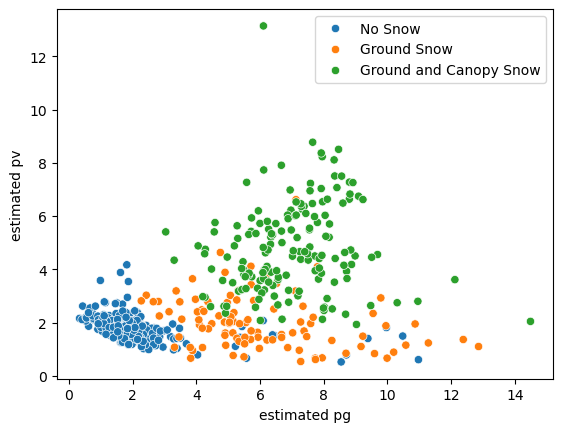

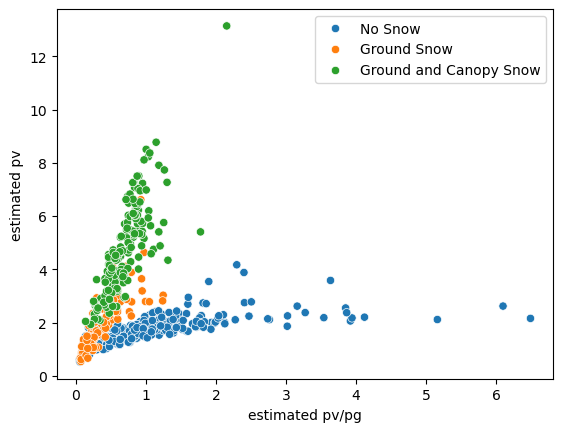

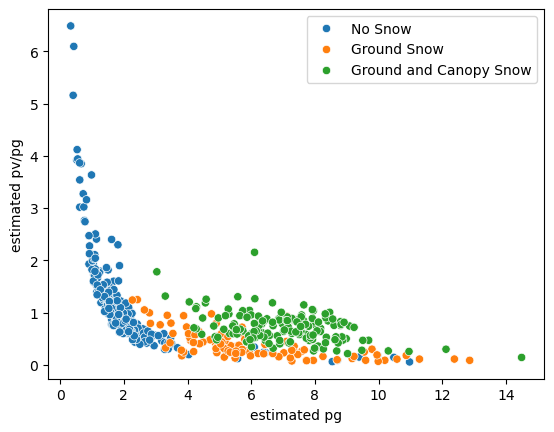

607


,camera,date,lat,lon,pvpg,pv,pg,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions
902,old_jack_pine,09/10/2023,53.911795,-104.684352,0.055025,0.603731,10.971891,29.561404,99.058438,0.0,0.0,1.0,23.0,0.000000,1.889532,1.889532,0.0,No Snow
911,old_jack_pine,09/10/2023,53.938823,-104.684352,0.211688,1.106129,5.225269,27.581818,112.397816,0.0,0.0,1.0,23.0,0.000000,1.548690,1.548690,0.0,No Snow
925,old_jack_pine,10/07/2023,53.920805,-104.714944,0.089847,0.782445,8.708684,24.361702,2.633845,0.0,0.0,0.0,21.0,0.000000,1.380555,1.380555,0.0,No Snow
1043,old_jack_pine,29/04/2023,53.902786,-104.638463,0.060719,0.518869,8.545366,27.641509,100.915144,0.0,0.0,1.0,20.0,0.000000,2.162172,2.162172,0.0,No Snow
1827,underc,08/11/2020,46.229395,-89.491715,0.268727,1.443093,5.370108,18.657143,5.393097,0.0,0.0,0.0,8.0,0.000000,1.661069,1.661069,0.0,No Snow
1830,underc,08/11/2020,46.256423,-89.491715,0.149024,1.398704,9.385768,21.250000,5.377418,0.0,0.0,0.0,8.0,0.000000,1.635559,1.635559,0.0,No Snow
2104,willowcreek,05/09/2020,45.801495,-90.046791,0.142284,1.490951,10.478689,27.264151,3.938785,0.0,0.0,0.0,7.0,0.000000,1.640595,1.640595,0.0,No Snow
2106,willowcreek,05/09/2020,45.819514,-90.046791,0.181738,1.811201,9.966001,33.000000,3.568269,0.0,0.0,0.0,7.0,0.000000,1.912085,1.912085,0.0,No Snow
2119,willowcreek,06/03/2024,45.801495,-90.111409,0.118299,0.659337,5.573489,26.545455,155.074660,0.0,0.0,1.0,18.0,0.000000,1.502322,1.502322,0.0,No Snow
2170,willowcreek,15/06/2019,45.774468,-90.111409,0.339627,2.070656,6.096850,28.719298,1.510830,0.0,0.0,0.0,3.0,0.456140,1.703342,1.703342,0.0,No Snow


In [9]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_outlier22_th3_1km_noprior_ta.pkl')
# print(df.columns)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean'
}).reset_index()
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    # &(df_grouped['pvpg']>.5)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.8)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<2)&(df_grouped['pvpg']>.5)&(df_grouped['pv']>2)&(df_grouped['FSC'] > .8)
    # &(df_grouped['pvpg']<.5)&((df_grouped['FSC'] < .5)|(df_grouped['TreeSnow'] > 0))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)

    &(df_grouped['pv_ratio_mean'] >= 1.3)&(df_grouped['snr']>.5)

    # &(df_grouped['data_quantity'] >= 18)]
    &((df_grouped['layer_flag'] <= .7)|(df_grouped['msw_flag'] < 1))&(df_grouped['data_quantity'] >= 18)]
    # &(df_grouped['layer_flag'] <= .8)&(df_grouped['data_quantity'] > 10)]

data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.ceil(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
# plt.xlim(0,12)
# plt.ylim(0,10)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pv/pg')
plt.ylabel('estimated pv')
# plt.xlim(0,3)
# plt.ylim(0,12)
# plt.plot([0.29,0.29],[0,1.32],'r--')
# plt.plot([0.5,0.5],[1.53,7],'r--')
# plt.plot([0.3,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pvpg', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv/pg')
# plt.xlim(0,20)
# plt.ylim(0,20)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(data))
data[(data['pg']>4.5)&(data['JointSnow']==0)]#.sort_values('snr')

In [4]:
df[(df['camera']=='old_jack_pine')&(df['date']=='09/10/2023')]

,camera,date,lon,lat,pvpg,pv,pg,Eg,Ev,data_quantity,...,h_te_interp,h_te_std,terrain_slope,longitude,latitude,cloud_flag_atm,layer_flag,FSC,TreeSnow,file_index
44446,old_jack_pine,09/10/2023,-104.730241,53.884768,0.796583,1.37137,1.721564,1.137931,0.379310,31,...,495.876556,0.173164,-0.000746,-104.731504,53.880320,0.0,1.0,0.0,0.0,23
44447,old_jack_pine,09/10/2023,-104.730241,53.884768,0.796583,1.37137,1.721564,1.357143,0.321429,31,...,495.851868,0.221267,0.000570,-104.731552,53.880619,0.0,1.0,0.0,0.0,23
44448,old_jack_pine,09/10/2023,-104.730241,53.884768,0.796583,1.37137,1.721564,0.960000,0.360000,31,...,495.802490,0.149574,-0.000782,-104.731649,53.881217,0.0,1.0,0.0,0.0,23
44449,old_jack_pine,09/10/2023,-104.730241,53.884768,0.796583,1.37137,1.721564,1.148148,0.148148,31,...,495.777802,0.173793,-0.000220,-104.731697,53.881516,0.0,1.0,0.0,0.0,23
44450,old_jack_pine,09/10/2023,-104.730241,53.884768,0.796583,1.37137,1.721564,1.347826,0.260870,31,...,495.154778,0.216486,-0.001508,-104.731731,53.881740,0.0,1.0,0.0,0.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45200,old_jack_pine,09/10/2023,-104.684352,53.947832,0.739792,0.96511,1.304570,0.727273,0.454545,14,...,483.996513,0.154550,-0.000164,-104.691656,53.947322,0.0,1.0,0.0,0.0,23
45201,old_jack_pine,09/10/2023,-104.684352,53.947832,0.739792,0.96511,1.304570,0.909091,0.272727,14,...,483.987015,0.061133,-0.000117,-104.691692,53.947546,0.0,1.0,0.0,0.0,23
45202,old_jack_pine,09/10/2023,-104.684352,53.947832,0.739792,0.96511,1.304570,0.866667,0.333333,14,...,483.968018,0.127529,-0.001282,-104.691765,53.947994,0.0,1.0,0.0,0.0,23
45203,old_jack_pine,09/10/2023,-104.684352,53.947832,0.739792,0.96511,1.304570,1.000000,0.210526,14,...,483.964722,0.126060,0.000298,-104.691813,53.948293,0.0,1.0,0.0,0.0,23
